# CEE 598: Uncertainty Quantification
## Assignment Five
### Noah Garfinkle (garfink2@illinois edu)
### 16 April 2020

## Imports and Set Up

In [15]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pytest
import chaospy as cp

## References

## General Solution Approach

Per the assignment guidelines, I have chosen approach (2), converting the provided MATLAB code into Python according to tasks one and two and verifying the code according to task three.

Per slide 6 of lecture 17, we consider the general approach to be:
1. Choose the polynomial type
2. Write the polynomial representationf or parameters
3. Pick the polynomial order for response
4. Write the polynomial representation for response
5. Calculate the unknown coefficients

## Task One

Using the three-term recurrence relation, write a generic code that evaluates the $n$-th order one-dimensional Hermite and Legendre polynomials, denoted by $P_n(x)$, at a prescribed numerical value for $x$.  The code can be written in the form of a single function that is called with a prescribed type of polynomial (either Hermite or Legendre).  Name your function evaluate_1D_polynomial.  So, the function will be called as follows

**evaluate_1D_polynomial(x,n,polynomial_type)**.

Using this function, plot the Hermite and Legendre polynomials of order ${0,1,2,3}$.  For Hermite polynomials, set the plotting range $x$ to be $[-3,3]$.

In [2]:
"""
d = dimension (integer)
p = order (integer)

returns n (integer)

calls: none
"""
def func_PCE_NumPols(d,p):
    n = 0
    for m1 in range(0,p+1):
        n += np.math.factorial(m1+d-1) / np.math.factorial(m1) / np.math.factorial(d-1)
    return int(n)

In [3]:
assert func_PCE_NumPols(4,3) == 35 # PASSES COMPARISON TO MATLAB CODE

In [4]:
def evaluate_1D_polynomial(x,n,polynomial_type):
    return 0

In [5]:
He_n = np.array([1,0])
He_nminus1 = np.array([1])

In [6]:
m1 = 3

In [7]:
np.convolve(np.array([1,0]), He_n) - (m1-1)*np.concatenate((np.zeros(2),He_nminus1))

array([ 1.,  0., -2.])

In [8]:
np.zeros(2)

array([0., 0.])

In [9]:
"""
p = degree (integer)
vargin = list of type and optional paraemeters
 Let vargin be a list, where the zero element is the type

returns c = coefficients (1*(p+1) real vector)

calls: none
"""
def func_PCE_1DPoly(p,vargin):
    polyType = vargin[0]
    c = []
    if polyType == "Hermite": # no other parameters 
        if p == 0:
            c = [1]
        elif p == 1:
            c = [1,0]
        else: # high order polynomials using recursion formula
            He_n = np.array([1,0])
            He_nminus1 = np.array([1])
            for m1 in range(2,p+1):
                c = np.convolve(np.array([1,0]), He_n) - (m1-1)*np.concatenate((np.zeros(2),He_nminus1))
                if m1 != p:
                    He_nminus1 = He_n
                    He_n = c
        c = (1/np.sqrt(np.math.factorial(p))) * c # normalization
    elif polyType == "Legendre": # no other parameters
        if p == 0:
            c = np.array([1])
        elif p == 1:
            c = np.array([1,0])
        else:
            He_n = np.array([1,0])
            He_nminus1 = np.array([1])
            for m1 in range(2,p+1):
                c = ((2*m1-1)/m1 * np.convolve(np.array([1,0]), He_n)) - ((m1-1)/m1) * np.concatenate((np.zeros(2),He_nminus1))
                if m1 != p:
                    He_nminus1 = He_n
                    He_n = c
        c = np.sqrt((2*p+1)/2) * c # normalization
    elif polyType == "Laguerre": # 1st index is a
        a = vargin[1]
        return "Not Implemented"
    elif polyType == "Chebyshev": # no other parameters
        return "Not Implemented"
    elif polyType == "Jacobi": # 1st index is a, 2nd index is b
        a = vargin[1]
        b = varagin[2]
        return "Not Implemented"
    else:
        return "Not Implemented"
    return np.array(c)

In [10]:
np.testing.assert_allclose(func_PCE_1DPoly(3,["Hermite"]),np.array([0.4082,0,-1.2247,0]),rtol=1e-3)
np.testing.assert_allclose(func_PCE_1DPoly(3,["Legendre"]),np.array([4.6771,0,-2.8062,0]),rtol=1e-3)

In [11]:
"""
x = argument (d*1 real vector)
c = coefficients (n*1 real vector)
d = dimension (integer)
p = order (integer)
vargin = list of type and optional parameters
    a = Laguerre parameter (real scalar > -1)
    a,b = Jacobi paraemters (real scalars > -1)
    
returns y = scalar

calls: func_PCE_NumPols, func_PCE_MultiIndex
"""
def func_PCE_Chaos(x,c,d,p,varagin):
    return 0

In [12]:
"""
j = index (integer)
d = dimension (integer)

returns n = coefficients (1*d integer vector)

calls: itself recursively
"""
def func_PCE_MultiIndex(j,d):
    # compute the polynomial order
    index_p = 0
    index_pp = 1
    p = 0
    while j >= index_pp:
        index_p = index_pp
        index_pp += (np.math.factorial((p+1)+d-1) / np.math.factorial(p+1) / np.math.factorial(d-1))
        p += 1

    # compute the first idnex
    index_pp = index_p + 1
    newindex = 0
    n = np.zeros((1,d))
    
    for m1 in range(0,p+1):
        if j < index_pp:
            n[0] = p - m1
            print(n)
            if d != 1:
                for m2 in range(0,m1-1+1):
                    newindex += (np.math.factorial(m2+d-2) / np.math.factorial(m2) / np.math.factorial(d-2))
                    print(func_PCE_MultiIndex(newindex+j-index_p,d-1)) # this is where my error is, the size is correct but not the vlaues
#                     print(f"-->n:{n},{func_PCE_MultiIndex(newindex+j-index_p,d-1)}")
                    n[1:] = func_PCE_MultiIndex(newindex+j-index_p,d-1)
                    print(n)
        else:
            index_p = index_pp
            print(f"index_p:{index_p}")
            index_pp += (np.math.factorial(m1+1+d-2)/np.math.factorial(m1+1)/np.math.factorial(d-2))
    return n

In [13]:
func_PCE_MultiIndex(4,7) # not there yet

index_p:2
[[0. 0. 0. 0. 0. 0. 0.]]
index_p:2
[[0. 0. 0. 0. 0. 0.]]
index_p:2
[[0. 0. 0. 0. 0.]]
[[1. 1. 1. 1.]]
[[0. 0. 0. 0.]]
[[1. 1. 1.]]
[[0. 0. 0.]]
[[1. 1.]]
[[0. 0.]]
[[1.]]
[[0.]]
[[0.]]
[[1.]]
[[0.]]
[[0. 0.]]
[[0. 0.]]
[[1. 1.]]
[[0. 0.]]
[[1.]]
[[0.]]
[[0.]]
[[1.]]
[[0.]]
[[0. 0.]]


ValueError: could not broadcast input array from shape (1,2) into shape (0,3)

In [14]:
def poly_multiindex(p,d):
    return 0

## Task Two

Multi-dimensional polynomial bases are just the product of one-dimensional polynomials.  Based on your one-dimensional polynomial code, **evaluate_1D_polynomial**, write a code that evaluates the $i$-th $d$-dimensional Hermite or Legendre polynomial, denoted by $\Psi_i(x)$, at a given numerical vector sample $x={x_i}_{i=1}^d$.  The function will be called as follows

**polynomial_value = evaluate_multiD_polynomial(x,d,i,polynomial_type)**

Using this function, generate the (surface) plots of 2D Hermite and Legendre polynomials with $i={0,1,2,3}$.  For Hermite polynomials, set the plotting range of $x_1$ and $x_2$ to be $[-3,3]$.

### Note

For the relationship between a multi-dimensional index, $i$, and its corresponding combination of one-dimensional degrees, e.g. (2,1,0,1), you could use the convention shown on Slide 6 of March 31 Lecture.  

## Task Three

In this code verification task, verify your codes by testing whether it can separately recover the following two target functions (intentionally chosen to be polynomial):

$$f(x_1,...,x_2)=6+2x_1^2+0.2x_1^3+2.3x_1x_2-1.5x_2^2-0.8x_3$$

$$g(y_1,y_2)=-15+0.05y_2^2+3.2y_1y_2+0.3y_2^2$$

Consider all the 3 $x$ variables to be standard normal and the 2 $y$ variables to be uniform random variables in $[0,1]$, use teh corresponding orthogonal polynomials.  To do the verification, use multidimensional quadrature using tensor product.  For 1D quadrature rules, use Gauss-Hermite quadrature points for normal random variables and Gauss-Legendre quadrature points for uniform random variables.  These quadrature points and their weights can be easily found on the Internet.  You should choose the number of quadrature oints and explain your choices.

### Try chaospy

In [17]:
distribution_x = cp.J(cp.Normal(),cp.Normal(),cp.Normal())
distribution_y = cp.J(cp.Uniform(0,1),cp.Uniform(0,1))

In [24]:
abscissas,weights = cp.generate_quadrature(3,distribution,sparse=False)

In [35]:
# https://chaospy.readthedocs.io/en/master/tutorial.html
def foo(coord,param):
    return 6 + 2 * np.power(param[0],2) + 0.2 * np.power(param[0],3) + 2.3 * param[0] * param[1] - 1.5 * np.power(param[1],2) - 0.8 * param[2]

In [36]:
x1 = np.linspace(-3,3,10)
x2 = np.linspace(-3,3,10)
x3 = np.linspace(-3,3,10)

In [37]:
coord = np.meshgrid(x1,x2,x3)

In [38]:
samples = distribution_x.sample(50)

In [39]:
evals = [foo(coord,sample) for sample in samples.T]

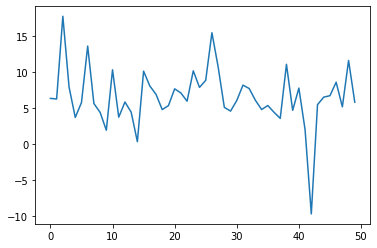

In [41]:
plt.plot(evals)

In [42]:
# https://chaospy.readthedocs.io/en/master/quadrature.html#gauss-legendre
